# Data Download

In [ ]:
mkdir /content/drive/MyDrive/candidate-resume-prediction

In [ ]:
cd /content/drive/MyDrive/candidate-resume-prediction

/content/drive/MyDrive/candidate-resume-prediction


In [ ]:
!wget https://he-s3.s3.ap-southeast-1.amazonaws.com/media/hackathon/hackerearth-machine-learning-challenge-resume-shortlisting/hire-the-perfect-candidate-5-c2bb6f5c/76fbb052f9b711eb.zip

--2021-08-25 10:55:42--  https://he-s3.s3.ap-southeast-1.amazonaws.com/media/hackathon/hackerearth-machine-learning-challenge-resume-shortlisting/hire-the-perfect-candidate-5-c2bb6f5c/76fbb052f9b711eb.zip
Resolving he-s3.s3.ap-southeast-1.amazonaws.com (he-s3.s3.ap-southeast-1.amazonaws.com)... 52.219.36.243
Connecting to he-s3.s3.ap-southeast-1.amazonaws.com (he-s3.s3.ap-southeast-1.amazonaws.com)|52.219.36.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4106086 (3.9M) [application/zip]
Saving to: ‘76fbb052f9b711eb.zip’

76fbb052f9b711eb.zi 100%[===================>]   3.92M  10.9MB/s    in 0.4s    

2021-08-25 10:55:43 (10.9 MB/s) - ‘76fbb052f9b711eb.zip’ saved [4106086/4106086]



In [ ]:
!unzip *.zip

In [ ]:
cd /content/drive/MyDrive/candidate-resume-prediction/dataset/

/content/drive/MyDrive/candidate-resume-prediction/dataset


In [ ]:
!apt-get install tree

In [ ]:
!tree .

# Processing

In [ ]:
First, the required libraries such as nltk, numpy, pandas, sklearn etc. were imported. 
The dataset was loaded using pandas dataframe.
The train dataset consisted of the Candidate ID and Match Percentage.
The train resume directly was added to the ID and the .pdf extension at the end to get the location of the corresponding resume.
Then tika library was imported for extracting the pdf text from each pdf, cleaned and added to a new column the dataframe, text.
Same was done for the test datset.
Then, tokenizer was called on the text column to get the encoded column.
This was passed to a linear regression model and it was used to generate prediction of Match Percentage from the test text column after tokenizing.
A new dataframe was created to get the Candidate ID column from test and Match Percentage from predicted output.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#Spacy
import spacy
nlp = spacy.load('en')

# Other
import re
import json
import string
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#Keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
cd /content/drive/MyDrive/candidate-resume-prediction/dataset/

/content/drive/MyDrive/candidate-resume-prediction/dataset


In [4]:
df = pd.read_csv('train.csv')

In [5]:
test = pd.read_csv('test.csv')

In [6]:
train_resumes_dir = '/content/drive/MyDrive/candidate-resume-prediction/dataset/trainResumes/'
test_resumes_dir = '/content/drive/MyDrive/candidate-resume-prediction/dataset/testResumes/'

In [7]:
df['file'] = df.apply(lambda row: train_resumes_dir + row['CandidateID'] + '.pdf', axis=1)

In [8]:
test['file'] = test.apply(lambda row: test_resumes_dir + row['CandidateID'] + '.pdf', axis=1)

# PDF extract 

In [ ]:
!pip install tika

In [10]:
from tika import parser # pip install tika
def extract_text(file):
  return parser.from_file(file)['content'].replace('\n', ' ').strip()

In [11]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText[13:].strip()

In [12]:
df['text'] = df.apply(lambda row: ' '.join(nltk.word_tokenize(cleanResume(extract_text(row['file'])))), axis=1)
test['text'] = test.apply(lambda row: ' '.join(nltk.word_tokenize(cleanResume(extract_text(row['file'])))), axis=1)

2021-08-26 06:39:26,104 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2021-08-26 06:39:28,825 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2021-08-26 06:39:29,216 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


In [ ]:
df.columns 

Index(['CandidateID', 'file', 'text', 'Match Percentage'], dtype='object')

In [13]:
df = df[['CandidateID', 'file', 'text','Match Percentage']]

In [14]:
test.head(1)

,CandidateID,file,text
0,candidate_014,/content/drive/MyDrive/candidate-resume-predic...,GRACE BAILRY M A C H I N E L E A R N I N G D E...


In [15]:
df.head(1)

,CandidateID,file,text,Match Percentage
0,candidate_011,/content/drive/MyDrive/candidate-resume-predic...,L I A M A N D R E W S FRESHER WORK EXPERIENCE ...,13.6


In [16]:
vocab = []
for i in df.iloc[:, 2]:
  vocab.append(i)
vocab = ' '.join(vocab).split()
vocab_size_text = len(set(vocab))
vocab_size_text

2738

In [17]:
tokenizer = Tokenizer(num_words=vocab_size_text)
tokenizer.fit_on_texts(df.text)
df_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(df.text))
test_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(test.text))

In [18]:
df_tokenized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
test_tokenized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2713,2714,2715,2716,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732,2733,2734,2735,2736,2737
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(90, 4)

# Failed with low accuracy model in deep learning

In [69]:
model = Sequential()
model.add(Dense(256, input_shape=(vocab_size_text,), activation='relu'))
# model.add((Dense(256, activation='relu')))
model.add((Dense(128, activation='relu')))
model.add((Dense(1, activation='relu')))
#compile model
model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

In [70]:
history = model.fit(df_tokenized, df.iloc[:, 3], validation_split = 0.1, epochs=319, verbose=1, shuffle=True)

Epoch 1/319
3/3 [==============================] - 1s 117ms/step - loss: 1707.7107 - accuracy: 0.0000e+00 - val_loss: 2333.6902 - val_accuracy: 0.0000e+00
Epoch 2/319
3/3 [==============================] - 0s 15ms/step - loss: 1531.0309 - accuracy: 0.0000e+00 - val_loss: 2091.3279 - val_accuracy: 0.0000e+00
Epoch 3/319
3/3 [==============================] - 0s 14ms/step - loss: 1270.1744 - accuracy: 0.0000e+00 - val_loss: 1745.1243 - val_accuracy: 0.0000e+00
Epoch 4/319
3/3 [==============================] - 0s 22ms/step - loss: 930.7805 - accuracy: 0.0000e+00 - val_loss: 1301.0873 - val_accuracy: 0.0000e+00
Epoch 5/319
3/3 [==============================] - 0s 14ms/step - loss: 559.2059 - accuracy: 0.0000e+00 - val_loss: 836.9772 - val_accuracy: 0.0000e+00
Epoch 6/319
3/3 [==============================] - 0s 14ms/step - loss: 282.8968 - accuracy: 0.0000e+00 - val_loss: 473.9299 - val_accuracy: 0.0000e+00
Epoch 7/319
3/3 [==============================] - 0s 13ms/step - loss: 213.8567

In [48]:
# Visualize training history
import matplotlib.pyplot as plt

def plot_acc_loss(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

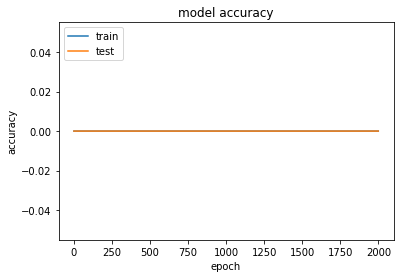

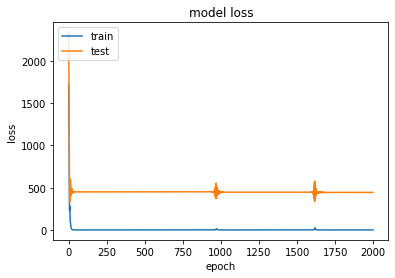

In [61]:
plot_acc_loss(history)

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
history.history['val_loss'].index(min(history.history['val_loss']))

7

In [73]:
history.history['loss'].index(min(history.history['loss']))

232

In [ ]:
X_train = df_tokenized.iloc[:, :].values
y_train = df.iloc[:, 3].values
X_test = test_tokenized.iloc[:, :].values

In [71]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

# Model

In [25]:
X_train = df_tokenized.iloc[:, :].values
y_train = df.iloc[:, 3].values
X_test = test_tokenized.iloc[:, :].values

# LR

In [44]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
y_pred

In [ ]:
pd.read_csv('sample_submission.csv')

In [28]:
output_data = test[['CandidateID']]

In [74]:
output_data['Match Percentage'] = y_pred

In [ ]:
output_data 

In [75]:
output_data.to_csv('output.csv', index = False)